In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv')
data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [2]:
X = data.drop('label',axis=1)
y = data['label']

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from tensorflow.python.framework import ops
label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(10))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
X_train = X_train.T/255
X_test = X_test.T/255
y_train = label_binarizer.transform(y_train)
y_test = label_binarizer.transform(y_test)
y_train = y_train.T
y_test = y_test.T

In [4]:
def get_placeholder(n_x,n_y):
    X = tf.placeholder(dtype=tf.float32,shape=[n_x,None],name='X')
    Y = tf.placeholder(dtype=tf.float32,shape=[n_y,None,],name='Y')
    return X,Y

In [5]:
def initialize_parameters(layer_dims):
    parameters={}
    for i in range(len(layer_dims)-1):
        parameters['W'+str(i+1)] = tf.get_variable('W'+str(i+1),shape = [layer_dims[i+1],layer_dims[i]],
                                                   dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
        parameters['b'+str(i+1)] = tf.get_variable('b'+str(i+1),shape=[layer_dims[i+1],1],initializer=tf.zeros_initializer())
    return parameters

In [6]:
def forward_propagation(X,parameters):
    L = len(parameters)//2
    X_prev = X
    for i in np.arange(L-1):
        Z = tf.add(tf.matmul(parameters['W'+str(i+1)],X_prev),parameters['b'+str(i+1)])
        X = tf.nn.relu(Z)
        X_prev = X
    ZL = tf.add(tf.matmul(parameters['W'+str(L)],X),parameters['b'+str(L)])
    return ZL

In [7]:
def compute_cost(Z,y):
    logits = tf.transpose(Z)
    labels = tf.transpose(y)
    cost = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels)
    return tf.reduce_mean(cost)

In [8]:
def random_min_batches(X_train,Y_train,minibatch_size,seed):
    m = X_train.shape[1]
    np.random.seed(seed)
    index = range(m)
    np.random.shuffle(index)
    X_train = X_train.iloc[:,index]
    Y_train = Y_train[:,index]
    num = int(m/minibatch_size)
    cur = 0
    mini_batches = []
    for i in range(num):
        minibatch_X = X_train.iloc[:,cur:(cur+minibatch_size)]
        minibatch_Y = Y_train[:,cur:cur+minibatch_size]
        cur += minibatch_size
        mini_batches.append((minibatch_X,minibatch_Y))
    minibatch_X=X_train.iloc[:,cur:]
    minibatch_Y=Y_train[:,cur:]
    mini_batches.append((minibatch_X,minibatch_Y))
    return mini_batches

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 400, minibatch_size = 32, print_cost = True,layer_dims=[784,30,10]):
    tf.reset_default_graph()
    costs = []
    seed = 3
    nx = X_train.shape[0]
    m = X_train.shape[1]
    ny = 10
    X,Y=get_placeholder(nx,ny)
    parameters = initialize_parameters(layer_dims)
    Z = forward_propagation(X,parameters)
    cost = compute_cost(Z,Y)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            seed = seed + 1
            epoch_cost = 0.    
            mini_batches = random_min_batches(X_train,Y_train,minibatch_size,seed)
            for mini_batch in mini_batches:
                (minibatch_X,minibatch_Y) = mini_batch
                _ , minibatch_cost = sess.run([optimizer,cost], feed_dict={X:minibatch_X,Y:minibatch_Y})
                epoch_cost += minibatch_cost/int(m/minibatch_size)

            if print_cost == True and epoch%20 == 0:
                print('cost after iteration %i %f'%(epoch,epoch_cost))
                print('train accacy ',accuracy.eval({X:X_train,Y:Y_train}))
                print('test accucy',accuracy.eval({X:X_test,Y:Y_test}))
            if print_cost == True and epoch%5==0:
                costs.append(epoch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        parameters = sess.run(parameters)

        return parameters

cost after iteration 0 2.339454
('train accacy ', 0.090646259)
('test accucy', 0.084285714)
cost after iteration 20 1.365885
('train accacy ', 0.69649661)
('test accucy', 0.70912701)
cost after iteration 40 0.820305
('train accacy ', 0.80105442)
('test accucy', 0.8125397)
cost after iteration 60 0.611819
('train accacy ', 0.84217685)
('test accucy', 0.84952378)
cost after iteration 80 0.509947
('train accacy ', 0.86418366)
('test accucy', 0.87277776)
cost after iteration 100 0.449284
('train accacy ', 0.87850338)
('test accucy', 0.88507938)
cost after iteration 120 0.408672
('train accacy ', 0.88717687)
('test accucy', 0.89174604)
cost after iteration 140 0.379653
('train accacy ', 0.89394557)
('test accucy', 0.8976984)
cost after iteration 160 0.357679
('train accacy ', 0.89918369)
('test accucy', 0.90238094)
cost after iteration 180 0.340420
('train accacy ', 0.90357143)
('test accucy', 0.90531749)
cost after iteration 200 0.326274
('train accacy ', 0.90809524)
('test accucy', 0.9080

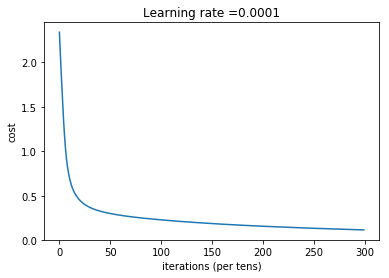

In [10]:
parameters = model(X_train, y_train, X_test, y_test,layer_dims=[784,100,30,10],num_epochs=1500)

In [247]:
parameters

NameError: name 'parameters' is not defined